In [67]:
# these allow you to modify source code of imports, notebook automatically updates
%load_ext autoreload
%autoreload 2
# show plots in notebook
%matplotlib inline 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from fastai.fastai.imports import *
from fastai.old.fastai.structured import *

# from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display

from sklearn import metrics

In [155]:
PATH = 'data/BAYZF-TIME_SERIES_INTRADAY.csv'
PATH_SUPPL = 'data/BAYZF-TIME_SERIES_DAILY.csv'
dateColumn = "timestamp"

df_BAYZF = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_BAYZF.rename(index=str, columns={"open": "sale_price"}, inplace=True)
df_SUPPL = pd.read_csv(PATH_SUPPL, low_memory=False, parse_dates=[dateColumn])
data_suppl = df_SUPPL["open"].values

df_BAYZF.head()

,timestamp,sale_price,high,low,close,volume
0,2019-02-14 11:20:00,74.00,74.00,74.00,74.00,100
1,2019-02-14 09:45:00,74.43,74.43,74.43,74.43,221
2,2019-02-13 12:40:00,76.88,76.88,76.82,76.82,0
3,2019-02-13 12:25:00,76.82,76.88,76.82,76.88,3000
4,2019-02-13 09:50:00,77.00,77.00,77.00,77.00,0


In [156]:
add_datepart(df_BAYZF, dateColumn, time=True)
add_datepart(df_SUPPL, dateColumn, time=True)
df_BAYZF.head()

,sale_price,high,low,close,volume,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,...,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed
0,74.00,74.00,74.00,74.00,100,2019,2,7,14,3,...,False,False,False,False,False,False,11,20,0,1550143200
1,74.43,74.43,74.43,74.43,221,2019,2,7,14,3,...,False,False,False,False,False,False,9,45,0,1550137500
2,76.88,76.88,76.82,76.82,0,2019,2,7,13,2,...,False,False,False,False,False,False,12,40,0,1550061600
3,76.82,76.88,76.82,76.88,3000,2019,2,7,13,2,...,False,False,False,False,False,False,12,25,0,1550060700
4,77.00,77.00,77.00,77.00,0,2019,2,7,13,2,...,False,False,False,False,False,False,9,50,0,1550051400


In [157]:
df_SUPPL.head()

,open,high,low,close,volume,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,...,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed
0,73.838,73.838,73.838,73.838,76,2019,2,7,15,4,...,False,False,False,False,False,False,0,0,0,1550188800
1,74.430,74.430,73.838,73.838,566,2019,2,7,14,3,...,False,False,False,False,False,False,0,0,0,1550102400
2,77.000,77.000,76.820,76.820,7689,2019,2,7,13,2,...,False,False,False,False,False,False,0,0,0,1550016000
3,76.400,76.400,76.400,76.400,78,2019,2,7,12,1,...,False,False,False,False,False,False,0,0,0,1549929600
4,76.400,76.400,76.400,76.400,195,2019,2,7,11,0,...,False,False,False,False,False,False,0,0,0,1549843200


In [163]:
start_hour = 9
start_minute = 30
end_hour = 4
end_minute = 0

def day_to_start_price_map(df, price_field, indices=True, toCount=False):
    # map of unique_days to their starting price
    unique_days = {}
    counts = {}
    for row in range(len(df[price_field])):
        year = df["timestampYear"][row]
        month = df["timestampMonth"][row]
        week = df["timestampWeek"][row]
        day = df["timestampDay"][row]
        data = (year, month, week, day)
        if indices:
            if data in unique_days:
                unique_days[data].append(row)
            else:
                unique_days[data] = [row]
        else:         
            if data not in unique_days:
                unique_days[data] = df[price_field][row]
            else:
                unique_days[data] = df[price_field][row]
        if toCount:
            if data in counts:
                counts[data] += 1
            else:
                counts[data] = 1
    if toCount:
        return unique_days, counts
    
    return unique_days

# print(day_to_start_price_map(df_BAYZF, "new_price", True))
# print(" ")
# print(day_to_start_price_map(df_SUPPL, "open", False))

# 6 hours * 12 five min intervals per hour + 6 five min intervals from 9:30 to 10
total_intervals = 6*12 + 6

def create_new_df():
    def assign_interval(hour, minute):
            if hour == 9:
                intervalCheck = (minute - 30) / 5
            else:
                intervalCheck = minute / 5 + (hour - 10)*12 + 6
            return intervalCheck
    
    day_to_price = day_to_start_price_map(df_BAYZF, "sale_price", True)
    day_to_price_start = day_to_start_price_map(df_SUPPL, "open", False)
    day_to_price_close = day_to_start_price_map(df_SUPPL, "close", False)
    first=True    
    for day in day_to_price:
        dataOpen = np.array([day_to_price_start[day] for interval in range(total_intervals)])
        dataClose = np.array([day_to_price_close[day] for interval in range(total_intervals)])
        dataPrice = []
        list_counter = -1
        indexInDf = day_to_price[day][list_counter]
        price = day_to_price_start[day]
        hourChange = df_BAYZF["timestampHour"][indexInDf]
        minuteChange = df_BAYZF["timestampMinute"][indexInDf]
        intervalCheck = assign_interval(hourChange, minuteChange)
        for interval in range(total_intervals):
            if interval == intervalCheck:
                # updates price as a change has been detected
                price = df_BAYZF["sale_price"][indexInDf]
                try:
                    # updates the list counter and the other variables
                    list_counter -= 1
                    indexInDf = day_to_price[day][list_counter]
                    hourChange = df_BAYZF["timestampHour"][indexInDf]
                    minuteChange = df_BAYZF["timestampMinute"][indexInDf]
                    intervalCheck = assign_interval(hourChange, minuteChange)
                except:
                    pass
                    
            dataPrice.append(price)
        
        dataPrice = np.array(dataPrice)
            
        hours = np.array([0 for interval in range(total_intervals)])
        minutes = np.array([0 for interval in range(total_intervals)])
        for i in range(total_intervals):
            if i < 6:
                hours[i] = 9
                minutes[i] = 30 + 5*i
            else:
                minutes[i] = (5*(i-6) % 60)
                if i < 18:
                    hours[i] = 10
                elif i < 30:
                    hours[i] = 11
                elif i < 42:
                    hours[i] = 12
                elif i < 54:
                    hours[i] = 1
                elif i < 66:
                    hours[i] = 2
                else:
                    hours[i] = 3
                    
        year, month, week, day = day
        toAdd = {"sale_price": dataPrice,
                 "price_close": dataClose,
                 "open": dataOpen,
                 "timestamp": str(month) + "/" + str(day) + "/" + str(year),
                 "hour": hours,
                 "minute": minutes}
        dfAdd = pd.DataFrame.from_dict(toAdd)
        
        if first:
            df = dfAdd
            first=False
        else:
            df = df.append(dfAdd, ignore_index=True)
            
    return df

In [164]:
df_formatted = create_new_df()
add_datepart(df_formatted, "timestamp")

In [249]:
def rmse(x, y):
    return math.sqrt(((x-y)**2).mean())

# function for print r2 and RMSE of training data and validation data
def print_score(rf):
    res = [rmse(rf.predict(X_train), y_train), rmse(rf.predict(X_valid), y_valid), rf.score(X_train, y_train), rf.score(X_valid, y_valid)]
    if hasattr(rf, 'oob_score_'): res.append(rf.oob_score_)
    print(res)
    
# splits dataset based on how many you want to train/validate
def split_vals(a, n):
    return a[:n].copy(), a[n:].copy()

In [226]:
to_predict = "sale_price"
result = proc_df(df_formatted, y_fld=to_predict)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = total_intervals*5 # predict the last 5 days
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_formatted, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_pred_day_price = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_pred_day_price.fit(X_train, y_train)
print_score(rf_pred_day_price)

[0.126857162562248, 0.6209469363151813, 0.9928564108439272, 0.2504288812937375]


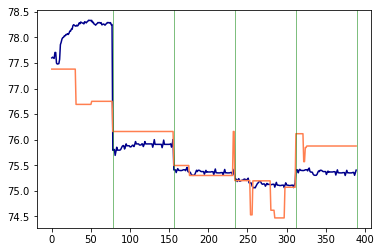

In [173]:
preds = rf_pred_day_price.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()

In [274]:
PATH = 'data/MMM-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_MMM = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_MMM.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_MMM, dateColumn, time=True)
df_MMM.head()

,sale_price,high,low,close,volume,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,...,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed
0,208.71,208.88,208.65,208.85,100664,2019,2,7,15,4,...,False,False,False,False,False,False,16,0,0,1550246400
1,208.57,208.69,208.57,208.69,25914,2019,2,7,15,4,...,False,False,False,False,False,False,15,59,0,1550246340
2,208.56,208.60,208.53,208.53,13805,2019,2,7,15,4,...,False,False,False,False,False,False,15,58,0,1550246280
3,208.53,208.59,208.49,208.59,16554,2019,2,7,15,4,...,False,False,False,False,False,False,15,57,0,1550246220
4,208.41,208.51,208.41,208.51,16589,2019,2,7,15,4,...,False,False,False,False,False,False,15,56,0,1550246160


In [276]:
def create_open_col(df): 
    res = day_to_start_price_map(df, "sale_price", False, True)
    day_to_price_start = res[0]
    counts = res[1]
    first = True
    for day in day_to_price_start:
        dataOpen = np.array([day_to_price_start[day] for interval in range(counts[day])])
        if first:
            first = False
            net_data = dataOpen
        else:
            net_data = np.append(net_data, dataOpen)
            
    return net_data
            
new_open_col = create_open_col(df_MMM)
df_MMM['open'] = new_open_col
df_MMM.head()

,sale_price,high,low,close,volume,timestampYear,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,...,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed,open
0,208.71,208.88,208.65,208.85,100664,2019,2,7,15,4,...,False,False,False,False,False,16,0,0,1550246400,206.81
1,208.57,208.69,208.57,208.69,25914,2019,2,7,15,4,...,False,False,False,False,False,15,59,0,1550246340,206.81
2,208.56,208.60,208.53,208.53,13805,2019,2,7,15,4,...,False,False,False,False,False,15,58,0,1550246280,206.81
3,208.53,208.59,208.49,208.59,16554,2019,2,7,15,4,...,False,False,False,False,False,15,57,0,1550246220,206.81
4,208.41,208.51,208.41,208.51,16589,2019,2,7,15,4,...,False,False,False,False,False,15,56,0,1550246160,206.81


In [277]:
to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_MMM, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 30 # predict part of the last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_MMM, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_MMM = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5, oob_score=True)
rf_MMM.fit(X_train, y_train)
print_score(rf_MMM)

[0.045966842056394557, 0.2116514008602702, 0.9997201544818272, 0.5715229330873319, 0.9994186845462599]


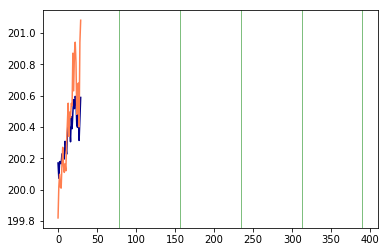

In [278]:
preds = rf_MMM.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()

In [288]:
PATH = 'data/HON-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_HON = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_HON.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_HON, dateColumn, time=True)
df_HON.head()
            
new_open_col = create_open_col(df_HON)
df_HON['open'] = new_open_col

to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_HON, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 50 # predict part of the last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_HON, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_HON = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_HON.fit(X_train, y_train)
print_score(rf_HON)

[0.0290546285204344, 0.14610065819052953, 0.9995166388018358, -0.1223420891814484, 0.9990057219196582]


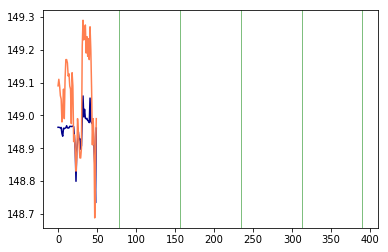

In [289]:
preds = rf_HON.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()

In [296]:
PATH = 'data/SYF-TIME_SERIES_INTRADAY.csv'
dateColumn = "timestamp"

df_SYF = pd.read_csv(PATH, low_memory=False, parse_dates=[dateColumn])
df_SYF.rename(index=str, columns={"open": "sale_price"}, inplace=True)
add_datepart(df_SYF, dateColumn, time=True)
df_SYF.head()
            
new_open_col = create_open_col(df_SYF)
df_SYF['open'] = new_open_col

to_predict = "sale_price"
to_drop = ['high', 'low', 'volume']
result = proc_df(df_SYF, y_fld=to_predict, skip_flds=to_drop)
df = result[0]
y = result[1]

to_remove = np.argwhere(np.isnan(y))
if len(to_remove) > 0:
    print('removing some nan cols')
    to_remove = [row[0] for row in to_remove.tolist()]
    print(to_remove)
    df = df.drop(to_remove, axis=0)
    y = y[~np.isnan(y)]

n_valid = 60 # predict part of the last day
n_train = len(df) - n_valid
# raw just uses the df_formatted
raw_train, raw_valid = split_vals(df_SYF, n_train)
X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)

rf_SYF = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, n_jobs=-1, bootstrap=True, max_features=0.5)
rf_SYF.fit(X_train, y_train)
print_score(rf_SYF)

[0.010536113615905033, 0.024823566354522597, 0.9995111097058029, 0.7697256645119704]


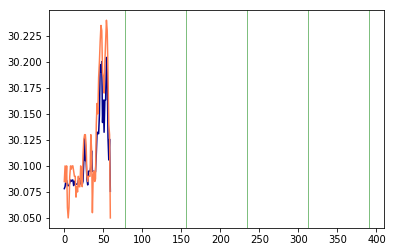

In [297]:
preds = rf_SYF.predict(X_valid)
x = [i for i in range(len(preds))]
plt.plot(x,preds, color='darkblue')
plt.plot(x, y_valid, color='coral')
for i in range(1, 6):
    plt.axvline(x=78*i, color='green', linewidth=0.5)
plt.show()